In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import scipy.stats as stats
import statsmodels.api as smi 
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# loading of dataset from webscrapping
df = pd.read_csv('C:/Users/Ethan/Desktop/KM6312/Sg_Used Car/SG_usedcar.csv')
df = df.drop(['Unnamed: 18'],axis=1)

In [3]:
# 把所有缺失值改为NAN，便于统一
df = df.replace('N.A', np.nan)
df = df.replace('N.A.', np.nan)
df = df.replace('NA', np.nan)

In [4]:
# 因为要研究特征与price之间的关系，所以去除Price为missing value的数据
df.dropna(subset=['Price'],inplace=True)
df = df.reset_index(drop=True)

In [5]:
# Preprocessing and Data cleaning

In [6]:
# 将登记日期改为年月日为单位
df.Reg_date = pd.to_datetime(df.Reg_date,format="%d-%b-%y")

In [7]:
# Annual depreciation = (Sales price-Dereg Value)/Remaining years of COE
# https://carsnap.sg/blog/calculate-parf-rebate-and-coe-rebate/#how-do-i-calculate-my-coe-rebate，现有信息无法算出deregistration value
# 本来打算根据公式计算并填充Dep为空置的值，但由于Price存在不透明性，也就是意味着Dep可能并不是正常值，所以暂且搁置

In [8]:
# 填充Curb_weight（空载重量）为空值的值，因为该值通常只与车辆品牌型号有关（也会与年份相关，为了简化不考虑了），如果存在相同的品牌型号即可填充
# 将 Curb Weight 列中的非数值数据转换为数值类型
df['Curb Weight'] = pd.to_numeric(df['Curb Weight'], errors='coerce')
# 计算每个品牌的 Curb Weight 平均值
curb_weight_by_brand_mean = df.groupby('Brand')['Curb Weight'].mean()
# 填充 Curb Weight 列的空值
for i, row in df.iterrows():
    if pd.isna(row['Curb Weight']):
        if row['Brand'] in curb_weight_by_brand_mean:
            df.at[i, 'Curb Weight'] = curb_weight_by_brand_mean[row['Brand']]

In [9]:
#填充Engine Cap为空值的值
df['Engine Cap'] = pd.to_numeric(df['Engine Cap'], errors='coerce')
Engine_Cap_by_brand_mean = df.groupby('Brand')['Engine Cap'].mean()

for i, row in df.iterrows():
    if pd.isna(row['Engine Cap']):
        if row['Brand'] in curb_weight_by_brand_mean:
            df.at[i, 'Engine Cap'] = Engine_Cap_by_brand_mean[row['Brand']]

In [10]:
#填充Power为空值的值，数据表所呈现的规律显示如果brand一样，那么Power差距为个位数
df['Power'] = pd.to_numeric(df['Power'], errors='coerce')
Power_by_brand_mean = df.groupby('Brand')['Power'].mean()

for i, row in df.iterrows():
    if pd.isna(row['Power']):
        if row['Brand'] in curb_weight_by_brand_mean:
            df.at[i, 'Power'] = Power_by_brand_mean[row['Brand']]

In [11]:
# 填充Road tax为空值的值，数据表所呈现的规律显示如果brand一样，那么Road Tax一样
df['Road Tax'] = pd.to_numeric(df['Road Tax'], errors='coerce')
Road_Tax_brand_mean = df.groupby('Brand')['Road Tax'].mean()

for i, row in df.iterrows():
    if pd.isna(row['Road Tax']):
        if row['Brand'] in curb_weight_by_brand_mean:
            df.at[i, 'Road Tax'] = Road_Tax_brand_mean[row['Brand']]

In [12]:
# 因为Reg_date，Coe_left,Dep,Mileage,Dereg Value, COE, Manufactured, Transmission, OMV, ARF, No. of owners 这些值都涉及具体复杂的情况考量
# 所以删除所有关于这些特征带有missing value的数据
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
#将Coe_left改为以天数为单位，假设每年有365天，每月有30天，并命名为 Coe_left_days
# 定义一个函数来转换 'COE_left' 列的值为天数
import numpy as np

def convert_to_days(Coe_left_str):
    if isinstance(Coe_left_str, str):
        parts = Coe_left_str.split(' ')
        days_total = 0
        for part in parts:
            if 'yrs' in part or 'yr' in part:
                days_total += int(part.replace('yrs', '').replace('yr', '')) * 365
            elif 'mths' in part or 'mth' in part:
                days_total += int(part.replace('mths', '').replace('mth', '')) * 30
            elif 'days' in part or 'day' in part:
                days_total += int(part.replace('days', '').replace('day', ''))
        return days_total
    else:
        # 对于非字符串值，返回 NaN 或适当的标记值
        return np.nan

# 应用这个函数到 'COE_left' 列
df['Coe_left_days'] = df['Coe_left'].apply(convert_to_days)

In [14]:
# 定义一个函数来转换 'COE_left' 列的值为月数
def convert_to_months(Coe_left_str):
    if isinstance(Coe_left_str, str):
        parts = Coe_left_str.split(' ')
        years = 0
        months = 0
        days = 0
        for part in parts:
            if 'yrs' in part or 'yr' in part:
                years = int(part.replace('yrs', '').replace('yr', ''))
            elif 'mths' in part or 'mth' in part:
                months = int(part.replace('mths', '').replace('mth', ''))
            elif 'days' in part or 'day' in part:
                days = int(part.replace('days', '').replace('day', ''))
        total_months = years * 12 + months + days / 30.0  # 将天数转换为月的小数部分
        return total_months
    else:
        # 对于非字符串值，返回 NaN 或适当的标记值
        return np.nan

# 应用这个函数到 'COE_left' 列
df['Coe_left_months'] = df['Coe_left'].apply(convert_to_months)

In [15]:
# 提取每个brand的第一个单词作为品牌名字，并创建一个新列
df['Brand_name'] = df['Brand'].apply(lambda x: x.split()[0] if pd.notna(x) else x)

In [16]:
df

,Brand,Type,Reg_date,Coe_left,Dep,Mileage,Road Tax,Dereg Value,COE,Engine Cap,...,Manufactured,Transmission,OMV,ARF,Power,No. of Owners,Price,Coe_left_days,Coe_left_months,Brand_name
0,Honda Vezel 1.5A X Honda Sensing,SUV,2015-10-14,4yrs 4mths 7days COE left),10310,50000,682.0,31237,56001,1496.0,...,2015,Auto,19775,9775,96.0,2,49800,1587,52.233333,Honda
1,Suzuki Swift Sport 1.6M (COE till 12/2022),Hatchback,2007-12-28,1yr 6mths 21days COE left),8210,203000,1030.0,6656,21349,1586.0,...,2007,Manual,12154,13370,92.0,2,12800,566,18.700000,Suzuki
2,Porsche 718 Cayman 2.0A PDK,Sports Car,2017-07-19,6yrs 1mth 12days COE left),34200,21000,1200.0,106829,50110,1988.0,...,2017,Auto,71979,101563,220.0,1,259988,2232,73.400000,Porsche
3,Hyundai Elantra 1.6A Elite,Mid-Sized Sedan,2014-11-14,3yrs 5mths 7days COE left),11010,35000,738.0,31339,64900,1591.0,...,2014,Auto,13856,13856,97.0,1,44800,1252,41.233333,Hyundai
4,Kia Cerato 1.6A GT Line Sunroof,Mid-Sized Sedan,2019-07-04,8yrs 27days COE left),9450,21200,738.0,38416,30009,1591.0,...,2018,Auto,18894,18894,93.0,1,85800,2947,96.900000,Kia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,BMW 5 Series 520i,Luxury Sedan,2018-02-22,6yrs 8mths 15days COE left),17990,55000,1210.0,68148,39000,1998.0,...,2017,Auto,45675,55945,135.0,2,148800,2445,80.500000,BMW
2496,Subaru Forester 2.0X (COE till 12/2024),SUV,2010-04-03,3yrs 6mths 25days COE left),7500,172892,1447.0,14045,19657,1994.0,...,2010,Auto,19090,19090,110.0,3,26800,1300,42.833333,Subaru
2497,Mercedes-Benz C-Class C180,Luxury Sedan,2013-12-20,2yrs 6mths 13days COE left),15240,127000,740.0,35772,73989,1595.0,...,2013,Auto,29525,28335,115.0,4,52828,923,30.433333,Mercedes-Benz
2498,Mazda 3 1.5A Sunroof,Mid-Sized Sedan,2017-12-07,6yrs 6mths COE left),9340,40200,682.0,35419,42801,1496.0,...,2017,Auto,15108,10108,88.0,3,65800,2370,78.000000,Mazda


In [17]:
df.columns

Index(['Brand', 'Type', 'Reg_date', 'Coe_left', 'Dep', 'Mileage', 'Road Tax',
       'Dereg Value', 'COE', 'Engine Cap', 'Curb Weight', 'Manufactured',
       'Transmission', 'OMV', 'ARF', 'Power', 'No. of Owners', 'Price',
       'Coe_left_days', 'Coe_left_months', 'Brand_name'],
      dtype='object')

In [18]:
# create a list of fields to be converted to int
convert_dict = {'Dep': 'int64','Mileage': 'int64','Road Tax': 'int64',
               'COE': 'int64','OMV': 'int64','ARF': 'int64', 'Manufactured': 'int64',
               'No. of Owners': 'int64','Price': 'int64','Coe_left_days': 'int64',
                'Dereg Value':'int64','Engine Cap':'int64','Curb Weight':'int64',
                'Power':'int64','Type':'category'}

In [19]:
df = df.astype(convert_dict)

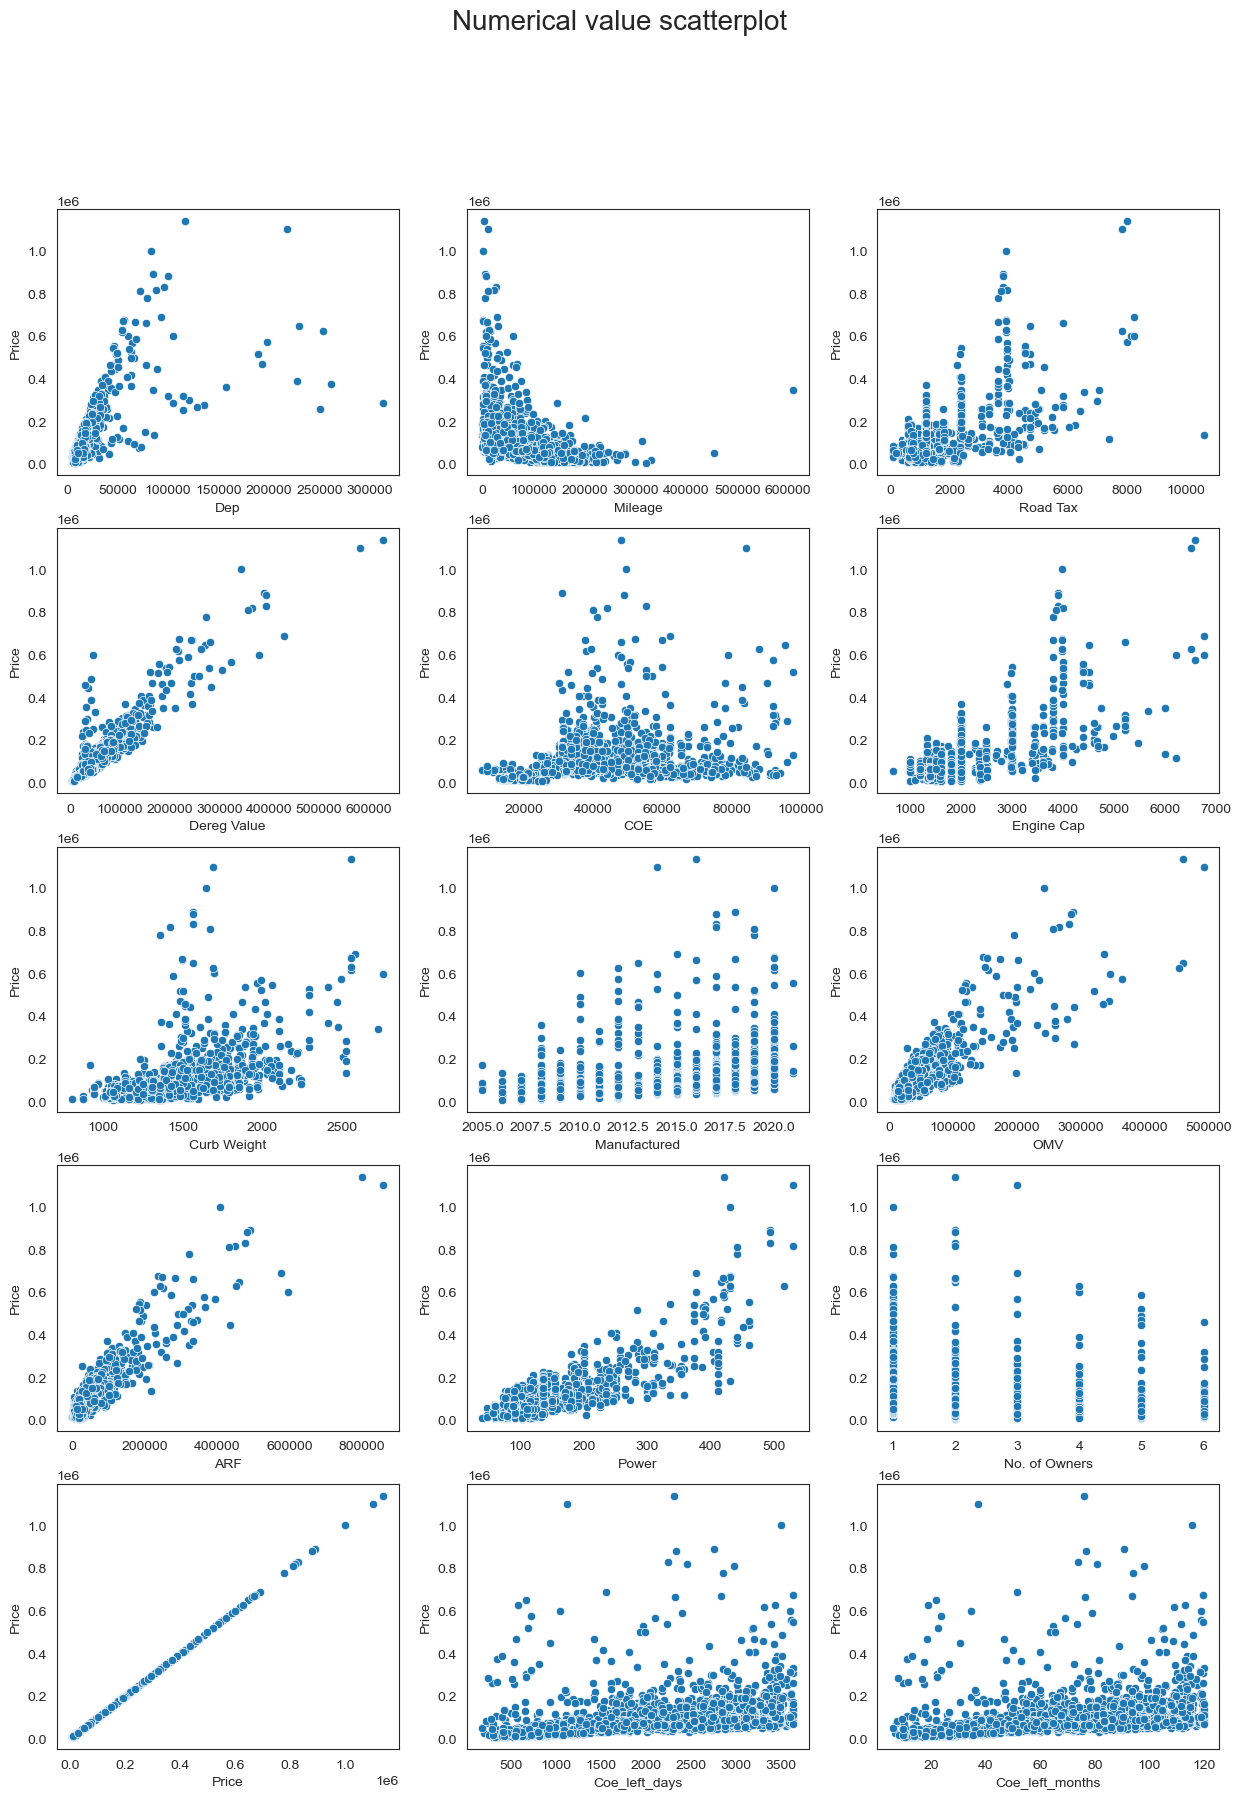

In [20]:
# 画出每个特征跟价格的相关性散点图，探寻规律
sns.set_style("white")
num_value_col = df.select_dtypes(include=['int64','float64']).columns.tolist()

# 创建了一个包含15个子图（5行x3列）的图表布局，每个子图的大小为18x16英寸。
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
fig.suptitle('Numerical value scatterplot',fontsize=20)

i=0
n=0
#遍历 num_value_col 中的每个特征名称。
#对于每个特征，使用 seaborn 的 scatterplot 函数绘制该特征与 Price 的散点图。ax=axes[i, n] 指定了绘图的子图位置。
for x,y in enumerate(num_value_col):
    p = sns.scatterplot(data=df,x=num_value_col[x],y='Price',ax=axes[i,n])
    p.set(xlabel = num_value_col[x])
#循环中的 if-else 语句控制着子图的位置。
#变量 i 和 n 分别表示行和列的索引。每次循环，n 会增加，当 n 达到2时（即第三列），下一个图会绘制在下一行的第一个位置（n 重置为0，i 增加）
    if n < 2:
        n+=1
    else:
        n=0
        i+=1
plt.show()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Brand            2500 non-null   object        
 1   Type             2500 non-null   category      
 2   Reg_date         2500 non-null   datetime64[ns]
 3   Coe_left         2500 non-null   object        
 4   Dep              2500 non-null   int64         
 5   Mileage          2500 non-null   int64         
 6   Road Tax         2500 non-null   int64         
 7   Dereg Value      2500 non-null   int64         
 8   COE              2500 non-null   int64         
 9   Engine Cap       2500 non-null   int64         
 10  Curb Weight      2500 non-null   int64         
 11  Manufactured     2500 non-null   int64         
 12  Transmission     2500 non-null   object        
 13  OMV              2500 non-null   int64         
 14  ARF              2500 non-null   int64  

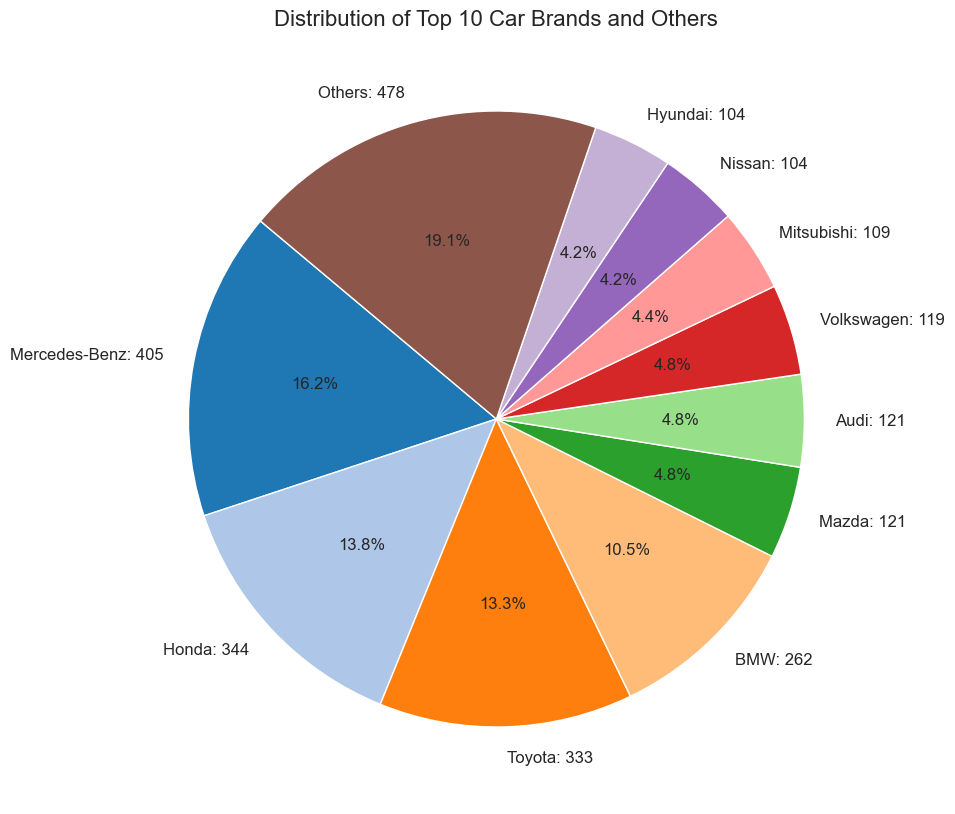

In [22]:
# Counting the frequency of each brand
brand_counts = df['Brand_name'].value_counts()

# Selecting the top 10 brands and grouping the rest under "Others"
top_10_brands = brand_counts[:10]  # Top 10 brands
others_count_10 = brand_counts[10:].sum()  # Sum of the rest
top_10_brands['Others'] = others_count_10  # Adding 'Others' category

# Generating a color palette for the pie chart
colors_10 = plt.cm.tab20(range(len(top_10_brands)))

# Plotting the pie chart for top 10 brands and others with larger font size for percentages
plt.figure(figsize=(10, 10))
plt.pie(top_10_brands, labels=[f'{label}: {count}' for label, count in top_10_brands.items()], autopct='%1.1f%%', startangle=140, colors=colors_10, textprops={'fontsize': 12})
plt.title('Distribution of Top 10 Car Brands and Others', fontsize=16) 
plt.show()


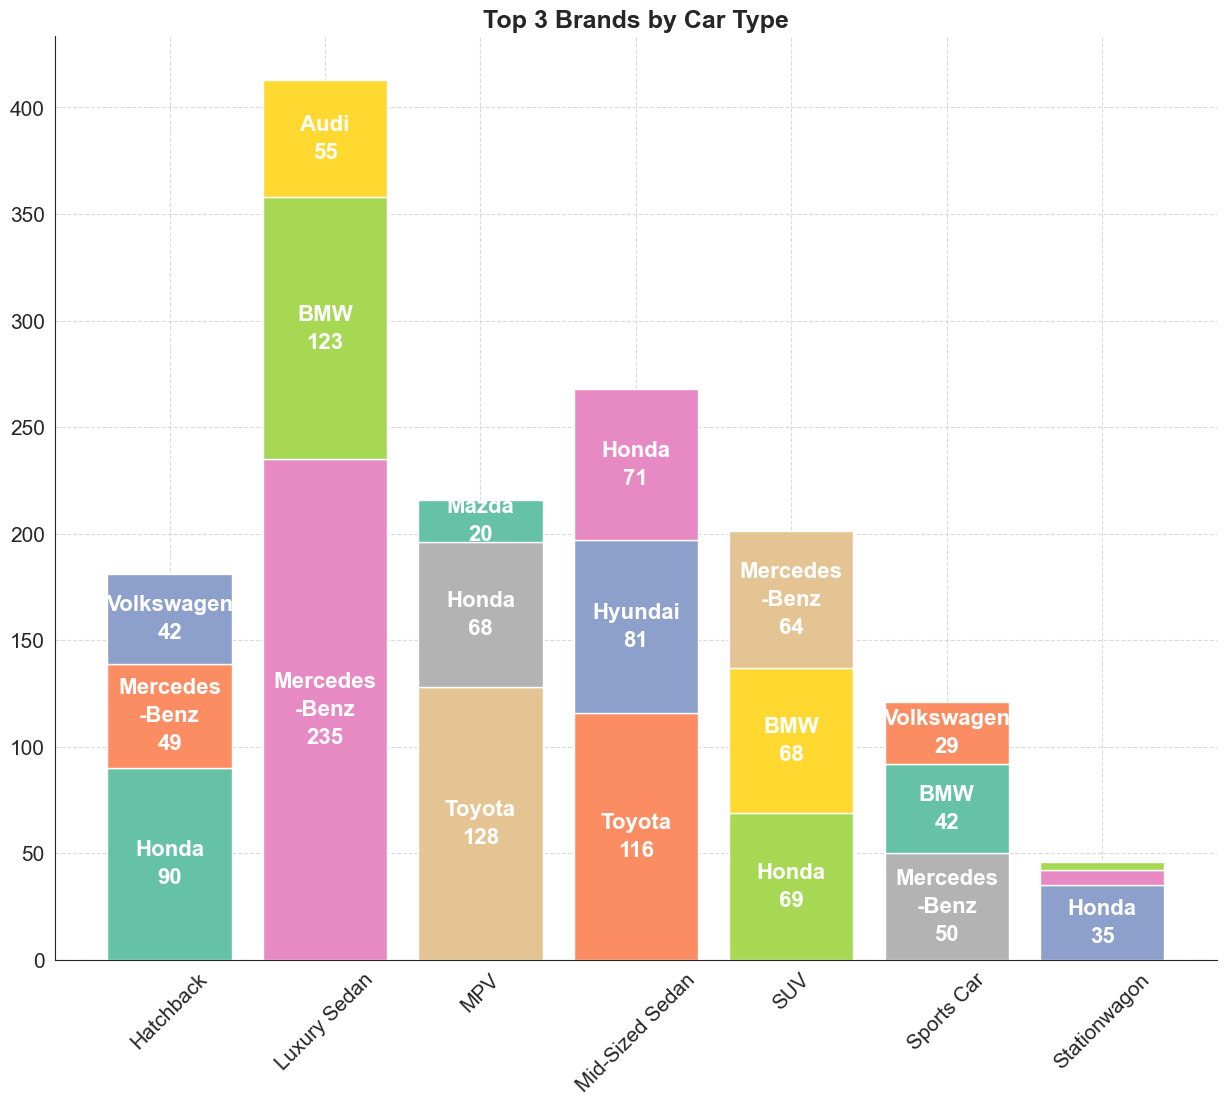

In [23]:
# Function to handle special case for "Mercedes-Benz" and split other brand names into two lines
def custom_split_brand_text(brand, count):
    """ Split 'Mercedes-Benz' into two lines and then add count on the third line.
        For other brands, split brand name and count into two lines. """
    if brand == 'Mercedes-Benz':
        return f"Mercedes\n-Benz\n{count}"
    return f"{brand}\n{count}"


# Preprocessing
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(subset=['Price'], inplace=True)
brand_counts = df['Brand_name'].value_counts()
top_10_brands_list = brand_counts.index.tolist()[:10]
df_top_10 = df[df['Brand_name'].isin(top_10_brands_list)]
type_counts_top_10_brands = df_top_10.groupby('Brand_name')['Type'].value_counts()
top_3_brands_per_type = type_counts_top_10_brands.groupby(level=1).nlargest(3).reset_index(level=0, drop=True)
top_3_brands_df = top_3_brands_per_type.reset_index(name='Count')
top_3_brands_df.rename(columns={'level_1': 'Type'}, inplace=True)


# Creating a bar plot with custom text formatting
plt.figure(figsize=(15, 12))
for car_type in top_3_brands_df['Type'].unique():
    df_subset = top_3_brands_df[top_3_brands_df['Type'] == car_type]
    bottom = 0
    for _, row in df_subset.iterrows():
        plt.bar(car_type, row['Count'], bottom=bottom, label=row['Brand_name'] if bottom == 0 else "", color=plt.cm.Set2.colors[_ % len(plt.cm.Set2.colors)])
        height = bottom + row['Count'] / 2
        if row['Count'] > 10:
            text_to_display = custom_split_brand_text(row['Brand_name'], row['Count'])
            plt.text(car_type, height, text_to_display, ha='center', va='center', color='white', fontsize=16, fontweight='bold', linespacing=1.5)
        bottom += row['Count']

plt.title('Top 3 Brands by Car Type', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.show()

In [24]:
top_3_brands_df

,Brand_name,Type,Count
0,Honda,Hatchback,90
1,Mercedes-Benz,Hatchback,49
2,Volkswagen,Hatchback,42
3,Mercedes-Benz,Luxury Sedan,235
4,BMW,Luxury Sedan,123
5,Audi,Luxury Sedan,55
6,Toyota,MPV,128
7,Honda,MPV,68
8,Mazda,MPV,20
9,Toyota,Mid-Sized Sedan,116


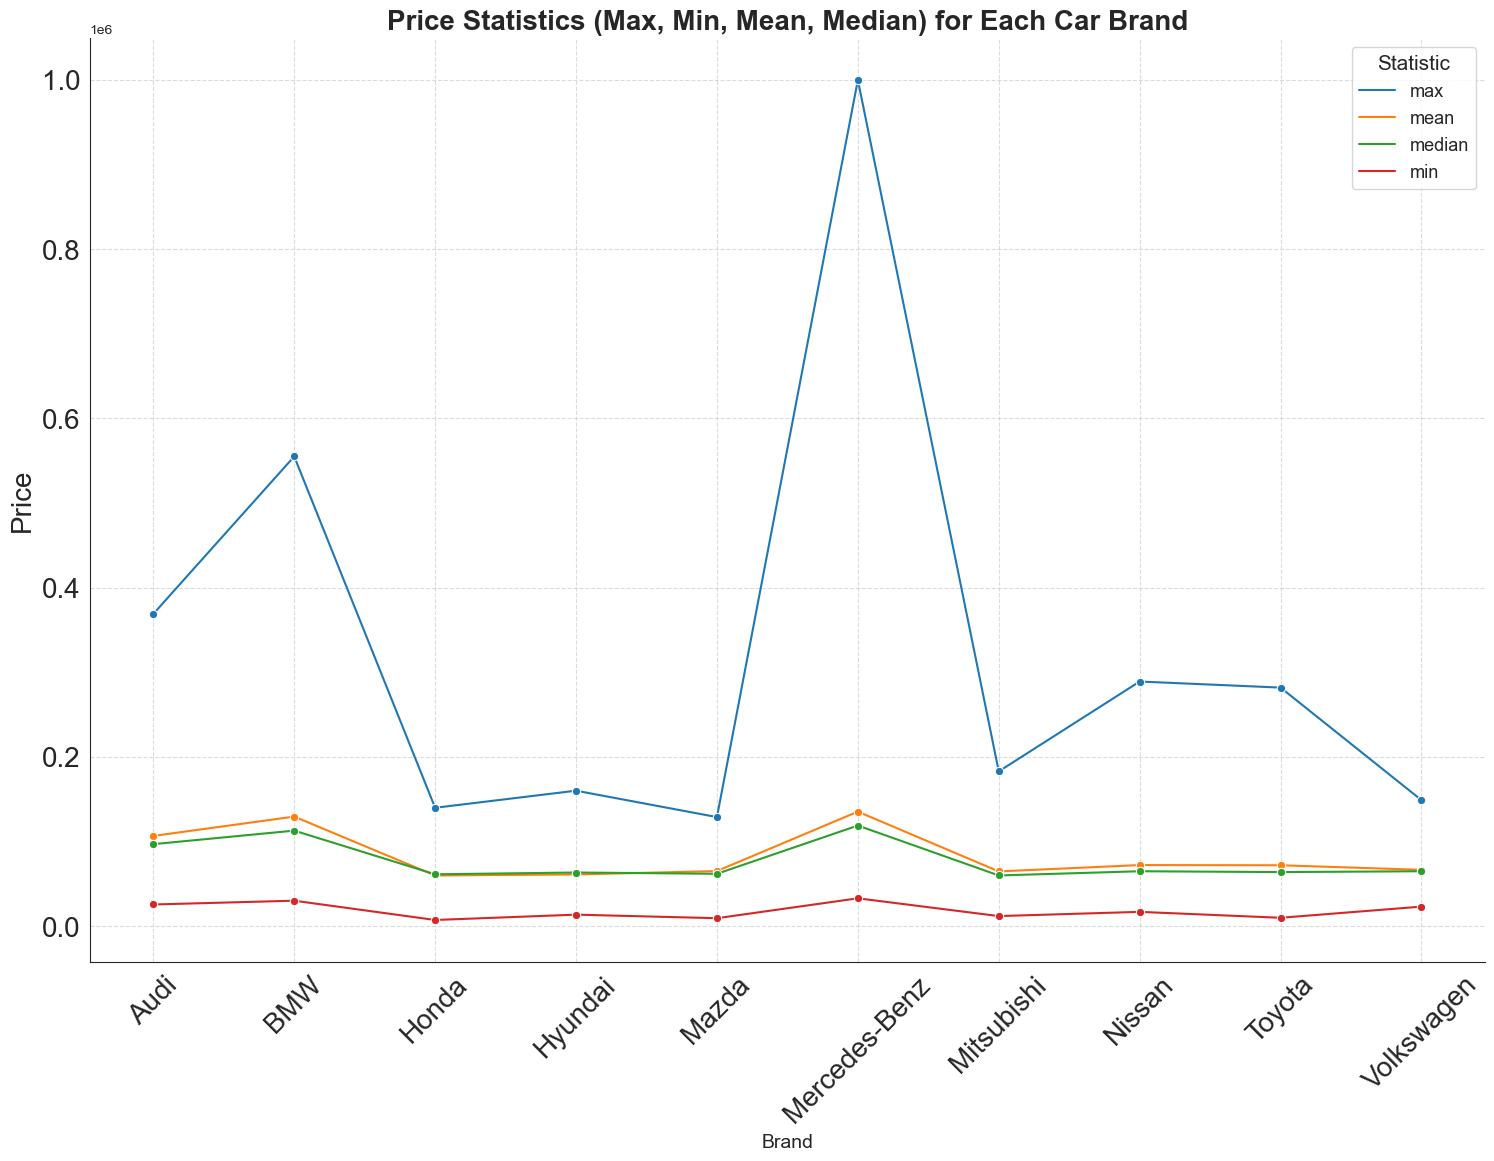

In [25]:
# Calculating the max, min, mean, and median price for each brand
brand_stats = df_top_10.groupby('Brand_name')['Price'].agg(['max', 'min', 'mean', 'median']).reset_index()

# Preparing data for line plot
line_data = brand_stats.melt(id_vars='Brand_name', var_name='Statistic', value_name='Price')
line_data.sort_values(by=['Brand_name', 'Statistic'], inplace=True)

# Creating a line plot
plt.figure(figsize=(18, 12))
sns.lineplot(x='Brand_name', y='Price', hue='Statistic', data=line_data, marker='o', palette='tab10')
plt.title('Price Statistics (Max, Min, Mean, Median) for Each Car Brand', fontsize=20, fontweight='bold')
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Price', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title='Statistic', title_fontsize='15', fontsize='13')
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.show()